Thanks for checking out this data analysis project. Three years ago I purchased a Chicago three flat, making me a homeowner, landlord, and investor all at once. Owning a multi-family home is a great way to begin investing in real estate. This program offers methods in analyzing data pulled from public home sales records from the Cook County Tax assessors office. 

We will be looking at 2-4 unit buildings in the City of Chicago. I have chosen 4 unit buldings as the cutoff for various reasons. The majority of multi-family properties that are over 4 units are usually more difficult for first time investors to afford. Multi-family homes over four units also have fewer mortgage options because they are considered a form of commercial property. Buildings with more than four units are tyically subject to stricter tax and building codes. Chicago owners of 2-4 unit multi-family homes are often beneficiaries of what is know as "Mom and Pop" exemptions. 

The primary goal of this project is to provide a set of analytical tools for anyone looking to invest in a Chicago multi-family home.

My overall strategy is to use public records from the Cook County Assessors office to identify trends in the housing market that will inform investors about how to compare land value in different neighborhoods, how to compare properties in different neighborhoods, and how to accurately project rental revenue by property.

Most of the import statements are modules common to data analysis in pyton. Sodappy and Socrata is a package and module that has to be used in order to access the Cook County API.

In [201]:
import requests
import json
import pandas as pd
from sodapy import Socrata
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sb

The records from Cook County assessor's residential sales data has 83 columns and 583,370 rows of information. While These records are open to the public, the ammount of time it takes for each API call made downloading a csv document the better choice.

Step one is the createtion of a pandas dataframe based on that document. Moving forward this will be the primary source of our data. On the second line I have replaced blank spaces in column titles with "_" in order to manage column titles more easily. The last two lines tells the dataframe to show all rows and columns. With this much data, rows and columns are often shown in a truncated format making it difficult to view available data. 

In [202]:
df=pd.read_csv('./Cook_County_Assessor_s_Residential_Sales_Data.csv')
df.rename(columns=lambda x:x.replace(' ', '_').lower(), inplace=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 



In [203]:
df.shape

(583370, 83)

Since we want to begin by looking at multi-family buildings that have been sold in the last three years we need to create a dataframe base on that criteria. Below I have created the "df_cv" data frame based on our primary dataframe but have narrowed hte results to only include homes with a property class designated as "211". This is the code for a multi-family home. The next line narrows the data frame to only multi-familly homes sold since 2017. This data frame will allow us to discover the most recent housing trends. 

I also saved this new data frame as a new csv file in order to avoid calling the incorrect data frame.

The final four lines are all commads to drop columns from the data frame. Many of these columns are either empty or unusable for our purposes, but If one needs to be restored we can go back to the original csv file we downloaded. 

In [204]:
x=df.loc[df['property_class']==211]
y=x.loc[x['sale_year']>=2017]

y.to_csv('df_cv_v2.csv', index=False)

df_cv=pd.read_csv('./df_cv_v2.csv')
# Following code ommits unneeded columns
df_cv.drop(['design_plan', 'cathedral_ceiling', 'construction_quality', 'renovation','site_desirability','garage_1_size','garage_1_material','garage_1_attachment','garage_1_area','garage_2_size','garage_2_material','garage_2_attachment','garage_2_area', 'porch','other_improvements','building_square_feet','repair_condition', 'sale_half-year', 'sale_quarter_of_year', 'sale_month_of_year','sale_half_of_year','age_squared','age_decade_squared', 'lot_size_squared', 'improvement_size_squared','pure_market_filter','square_root_of_lot_size', 'square_root_of_age','square_root_of_improvement_size'], axis=1, inplace=True)
df_cv.drop(['number_of_commercial_units','longitude','latitude','census_tract','multi_property_indicator','modeling_group','percent_ownership','condo_class_factor','large_lot','condition,_desirability_and_utility','o\'hare_noise','floodplain', 'road_proximity','condo_strata'],axis=1, inplace=True)
df_cv.drop(['neighborhood_code','use', 'number_of_units', 'multi-family_indicator'],axis=1, inplace=True)
df_cv.drop(['total_building_square_feet'],axis=1, inplace=True)


In [206]:
df_cv.shape


(34216, 35)

The next cells will remove all records for properties with more than 4 units. So out of 34,216 records we removed 2,338. 

In [368]:
df_cv=df_cv.loc[df_cv['apartments']<=4]
df_cv.shape

(19776, 36)

Several records have the same property address, but these are not neccesarily duplicates. Each record is based on a sale of property not on a single property.However many times a property has been sold in the last three years will be equal to the number of records the address shows up in our dataframe. 

This is not an issue unless we look at sale price. Many properties have been marked as being sold for a $1 or less. This indicates various possibilities: inherited property, forclosed homes, non-monetary trade. Whatever the case may be, we will remove any property from the df_cv data frame with a sale price of less than or equal to 1.

In [209]:
sp = df_cv[ df_cv['sale_price'] <= 1 ].index
df_cv.drop(sp, inplace=True)
df_cv.shape

(19842, 35)

First we need to focus on the neighborhoods selected for this project. The dicctionary below is a simple key for understanding some of the spatial layouts we are working with. 

The original csv file pulled from the Cook County public records provides a wealth of data, but it does not include the zip codes, which are widely used as identifiers for different areas. 

This csv file uses three different codes to identify specific neighborhoods. There is the Neighborhood Code, the Town code, and the Neighborhood and Town code. The Neighborhood code is nearly useless without the Town code as a prefix because there are numerous neighborhoods throughout cook county that have the same Neighborhood code but are not located close to one another. 

Town codes identify broader areas of cook county. When the town code prefix is followed by the neigborhood prefix we get the most targetted portion of the the neighborhood code.

Look at the first entry inside the "town_dct" below. West Chicago gets it's own town code "77" and conatins within it numerous Chicago neighborhoods. Ukranian Village, Wicker Park, and Pilsen are three of those neighborhoods. The codes following the specific neighborhoods have the Neighborhood and Town code using West Chicago code "77" as the prefix. Following the prefix is the neighborhood code(typically between 2 and 3). So when we want to reference data specifically about Pilsen, we locate it through the Town code at "77" and Neighborhood code "741", to arrive at "77141".

If you are familiar with these neighborhoods you know they are not all adjacent to one another. In essence, pulling the data for West Chicago will return records for all three of these neighborhoods along with various other neighborhoods.

Some neighborhoods, like Lakeview, have been defined as Lakeview and Lakeview_central. Cook County Assesors office has established codes for towns and neghborhoods, but they do not offer an index or dictionary that specifies which town codes belong to which towns. So the best way to approach neighborhoods marked as "central" is to treat it like one of West Chicago's neighborhoods.

In other words: lakeview_central is to lakeview as wicker_park is to west_chicago

I have also entered various zip codes for the all the neighborhoods and towns listed below. The correspondent zip codes will help us analyze which properties present the best investment opportunities. 

At any point in the analysis feel free to use town_dct as a reference.


In [210]:
town_dct={
        'west_chicago':{
        'town_code':77,
        'zips':[60612,60622,60642,60608],
        'ukrainian_village':7752,
        'wicker_park':77170,
        'pilsen':77141, 
        
    },
        'lower_east_side':{
            'town_code':70,
            'zips':[60615,60637],
            'hyde_park':7020, 
            'bronzeville':7010, 
    },
        'lincoln_park':{
            'town_code':74,
            'zips':[60614],
            'lincoln_park_central':7412
    },
        'lakeview':{
            'town_code':73,
            'zips':[60613,60657],
            'lakeview_central':7384
    },
        'logan_square':{
            'town_code': 71,
            'zips':[60647],
            'logan_square_central':7170
    },
        'rogers_park':{
            'town_code':75,
            'zips':[60626,60645],
            'rogers_park_central':7531
        
    },
        'lower_west_side':{
            'town_code':76,
            'zips':[60609],
            'bridgeport':7650, 
            'mckinley_park': 7660
        
    }  
}
town_dct

{'west_chicago': {'town_code': 77,
  'zips': [60612, 60622, 60642, 60608],
  'ukrainian_village': 7752,
  'wicker_park': 77170,
  'pilsen': 77141},
 'lower_east_side': {'town_code': 70,
  'zips': [60615, 60637],
  'hyde_park': 7020,
  'bronzeville': 7010},
 'lincoln_park': {'town_code': 74,
  'zips': [60614],
  'lincoln_park_central': 7412},
 'lakeview': {'town_code': 73,
  'zips': [60613, 60657],
  'lakeview_central': 7384},
 'logan_square': {'town_code': 71,
  'zips': [60647],
  'logan_square_central': 7170},
 'rogers_park': {'town_code': 75,
  'zips': [60626, 60645],
  'rogers_park_central': 7531},
 'lower_west_side': {'town_code': 76,
  'zips': [60609],
  'bridgeport': 7650,
  'mckinley_park': 7660}}

The following code returns the dataframe from df_cv filtered for each neighborhood listed in the above dictionary. This converts each neighborhood into its own data object. Feel free to enter any neighborhood listed below to see available data.

In [400]:
west_chicago = df_cv.loc[df_cv['town_code']==77]
ukranian_village=df_cv.loc[df_cv['town_and_neighborhood']==7752]
wicker_park=df_cv.loc[df_cv['town_and_neighborhood']==77170]
pilsen =df_cv.loc[df_cv['town_and_neighborhood']==77141]

lower_east_side=df_cv.loc[df_cv['town_code']==70]
hyde_park=df_cv.loc[df_cv['town_and_neighborhood']==7020]
bronzeville=df_cv.loc[df_cv['town_and_neighborhood']==7010]

lincoln_park=df_cv.loc[df_cv['town_code']==74]
lincoln_park_central =df_cv.loc[df_cv['town_and_neighborhood']==7411]

lakeview=df_cv.loc[df_cv['town_code']==73]
lakeview_central=df_cv.loc[df_cv['town_and_neighborhood']==7384]

logan_square=df_cv.loc[df_cv['town_code']==71]
logan_square_central=lakeview_central=df_cv.loc[df_cv['town_and_neighborhood']==7170]

rogers_park=df_cv.loc[df_cv['town_code']==75]
rogers_park_central=lakeview_central=df_cv.loc[df_cv['town_and_neighborhood']==7531]

lower_west_side=df_cv.loc[df_cv['town_code']==76]
bridgeport=df_cv.loc[df_cv['town_and_neighborhood']==7650]
mckinley_park=lakeview_central=df_cv.loc[df_cv['town_and_neighborhood']==7660]






Below are value references for some of the columns in our dataframe. Some of these columns refer to housing materials and whether certain portions of the property is fininshed. Refer back to this dictionary if needed.

In [214]:
wall_material={
    1:'wood',
    2:'masonry',
    3:'wood and masonry',
    4:'stucco'
}
roof_material={
    1:'shingle asphault',
    2:'tar and gravel',
    3:'slate',
    4:'shake',
    5:'tile',
    6:'other'
}
basement={
    1:'full',
    2:'slab',
    3:'partial',
    4:'crawl'
}
basement_finish={
    1:'full rec room',
    2:'apartment',
    3:'unfinised'
}
central_heating={
    1:'warm air',
    2:'hot water/steam',
    3: 'electric',
    4:'other'
}
other_heating={
    1:'floor furnace',
    2:'unit_heater',
    3:'stove',
    4:'solar',
    5:'none'
}
central_air={
    0:'unknown',
    1:'yes',
    2:'no'
}
attic_type={
    1:'full',
    2:'partial',
    3:'none'
}
attic_finish={
    1:'living area',
    2:'apartment',
    3:'unfinished'
}
most_recent_sale={
    0:'no',
    1:'yes'
}

Next we need to get rid of incomplete data and null values. There were several records missing addresses. This is a crucial piece of data so we'll drop all records missing addresses, but we will keep records missing "most recent sale value".

In [217]:
df_cv.dropna(subset = ["property_address"], inplace=True)

In [218]:
df_cv.isna().sum()

pin                            0
property_class                 0
land_square_feet               0
town_code                      0
type_of_residence              0
apartments                     0
wall_material                  0
roof_material                  0
rooms                          0
bedrooms                       0
basement                       0
basement_finish                0
central_heating                0
other_heating                  0
central_air                    0
fireplaces                     0
attic_type                     0
attic_finish                   0
half_baths                     0
multi_code                     0
estimate_(land)                0
estimate_(building)            0
sale_date                      0
deed_no.                       0
sale_price                     0
property_address               0
full_baths                     0
age                            0
sale_year                      0
sale_quarter                   0
most_recen

I'll take this opportunity to remove the parantheses from some of the column headers.  Doing so will allow us to make calls on those columns.

In [219]:
df_cv.rename(columns={'estimate_(land)': 'estimate_land'}, inplace=True)
df_cv.rename(columns={'estimate_(building)': 'estimate_building'}, inplace=True)
df.rename(columns={'estimate_(land)': 'estimate_land'}, inplace=True)
df.rename(columns={'estimate_(building)': 'estimate_building'}, inplace=True)

There are many ways to properly estimate the value of a property, but there are three main categories that will indicate a property's ability to generate revenue:

1.Location of the property
2.How many units and bedrooms it has
3.How to project rental revenue.

While we are working with a handful of specified neighborhoods that have shown to be good investments, we can get a better idea of location values by looking at the value of the land which is the overall property value minus the structures.

In this case our dataframe has a column of 'land_square_feet' and estimate_land. By returning the dollar value of each square foot in descending order, we can get a glimpse of which locations have the highest instrinsic value. 



In [220]:
w=((df_cv.estimate_land/df_cv.land_square_feet).sort_values(ascending=False))
w.describe(), w.median(), w.head()

(count    19776.000000
 mean        16.251200
 std         17.780605
 min          0.480000
 25%          7.750000
 50%         10.500000
 75%         15.586871
 max        540.340190
 dtype: float64,
 10.5,
 6077     540.340190
 566      436.696429
 32184    303.833333
 3825     261.428571
 2251     250.078125
 dtype: float64)

The above code divides the land value for each property by the square footage to show which properties are the most valuable by square footage of land. Take this opportunity to see which property is the most,least, and median expinsive. I'll look up the properties by index.

So according to our data, of multi-famliy homes sold in the past three years, the most valuable land is at 825 W Webster Ave at $540.34. (running the same

In [221]:
df_cv.loc[ 6077 , 'property_address' ], round((df_cv.loc[ 6077].estimate_land/df_cv.loc[ 6077].land_square_feet), 2)

('825 W WEBSTER AVE', 540.34)

According to our data frame the cheapest property is zero dollars. There is no explination why that property is valued at nothing, but we can assume there is some legal or environmental issue that makes it unfit for residential or commercial use. By looking at the tail() of the  list we can see the least valued property above zero is at index 10251 and its price per square foot is $.48 a square foot.

In [370]:
df_cv.loc[ 10251 , 'property_address' ], round((df_cv.loc[ 10251].estimate_land/df_cv.loc[ 10251].land_square_feet), 2)

('4325 S HONORE ST', 0.48)

$.48 per square foot seems a little low in the city of Chicago. Let's do a little digging to discover if there is more to the story

It's always possible that the land value was improperly recorded or assessed. But a quick google search reveals the property to be adjacent to a large manufacturing district. The home could also be riddled with mold, lead, or asbestos. It's also a 120 year old home where the wall material is marked as wood. Investors typically prefer the longevity of brick, especially in the city of chicago.

In [212]:
df_cv.loc[ 10251 ]

pin                             20064020090000
property_class                             211
land_square_feet                          3000
town_code                                   72
type_of_residence                            2
apartments                                   2
wall_material                                1
roof_material                                2
rooms                                        7
bedrooms                                     4
basement                                     3
basement_finish                              3
central_heating                              2
other_heating                                5
central_air                                  0
fireplaces                                   0
attic_type                                   1
attic_finish                                 3
half_baths                                   0
multi_code                                   2
estimate_land                             1440
building     

We can use this value by square footage to compare and contrast neighborhoods. Let's add a new column to the originnal df and df_cv for the land value by square foot. A quick comparison shows several differences in the value of property in logan square and lakeview. While Lakeview has only about a third of the properties that logan square does, its average price per sqare foot of land is 3.8x more than that of logan sqare. 

In [225]:
df['dollar_per_sq_foot_land']=df.estimate_land/df.land_square_feet
df_cv['dollar_per_sq_foot_land']=df_cv.estimate_land/df_cv.land_square_feet
df_cv.dollar_per_sq_foot_land

1         10.000000
4         22.000000
5         14.000000
6          7.000000
7          7.000000
11         7.000000
12         7.249912
16         5.000000
17        22.498305
18        13.000000
20         8.998656
22         8.750000
25        11.204172
26        10.497391
28         6.999812
29         3.249700
31         3.749618
35        11.000000
44        11.748677
46         9.000000
47         7.498908
48        10.498413
50        25.000000
54        11.747200
55        46.000000
57         7.248087
59        25.000000
62        10.499200
64         8.000000
68        11.000000
69        50.000000
70         6.000000
71         6.000000
72        11.750000
74        30.000000
76         4.250000
77        12.000000
78         7.498413
80        22.571815
81        21.997354
82        28.009571
85        13.500000
86        10.498413
91        11.000000
93        34.000000
95        15.998363
96        10.000000
97        11.748236
98        14.498667
99        10.999584


In [229]:
round(logan_square.dollar_per_sq_foot_land.describe(),2),round(lakeview.dollar_per_sq_foot_land.loc[lakeview['dollar_per_sq_foot_land']>0].describe(),2)

(count    3464.00
 mean       14.33
 std         4.29
 min         8.40
 25%        12.50
 50%        13.00
 75%        14.50
 max        96.79
 Name: dollar_per_sq_foot_land, dtype: float64,
 count    1238.00
 mean       54.82
 std        22.38
 min        13.95
 25%        42.00
 50%        50.00
 75%        60.00
 max       261.43
 Name: dollar_per_sq_foot_land, dtype: float64)

Let's use a histogram to compare the dollar per sq foot price of land from both neighborhoods. Logan Square's histogram shows that the vast majority of properties in this neighborhood have a land per square foot value between $7 and $25 while the majority of properties in Lakeview are between $25 and $70 per square foot of land. 

While this is useful for getting a current snapshop it doesn't tell up how  these prices have evolved over time.

Text(0, 0.5, 'Number of homes')

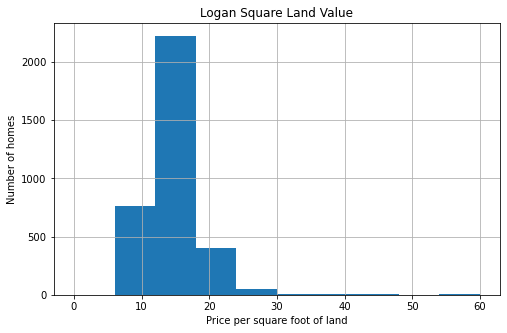

In [371]:
logan_square.dollar_per_sq_foot_land.hist(figsize=(8, 5),range=[0,60]);
plt.title('Logan Square Land Value')
plt.xlabel('Price per square foot of land')
plt.ylabel('Number of homes')

Text(0, 0.5, 'Number of homes')

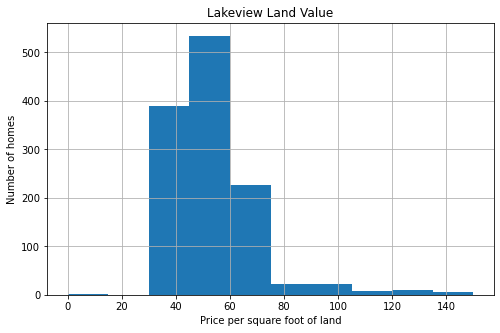

In [232]:
lakeview.dollar_per_sq_foot_land.hist(figsize=(8, 5 ),range=[0,150]);
plt.title('Lakeview Land Value')
plt.xlabel('Price per square foot of land')
plt.ylabel('Number of homes')

Below we have a scatterplot for all the dollars per square foot of land value for the logan square and lakeview neighborhoods from 2013 to 2019. Looking at the linear regresison line, there appears to be a slight upward trend where the price of land in this neghborhood has been increasing.

In [286]:

town_dct

{'west_chicago': {'town_code': 77,
  'zips': [60612, 60622, 60642, 60608],
  'ukrainian_village': 7752,
  'wicker_park': 77170,
  'pilsen': 77141},
 'lower_east_side': {'town_code': 70,
  'zips': [60615, 60637],
  'hyde_park': 7020,
  'bronzeville': 7010},
 'lincoln_park': {'town_code': 74,
  'zips': [60614],
  'lincoln_park_central': 7412},
 'lakeview': {'town_code': 73,
  'zips': [60613, 60657],
  'lakeview_central': 7384},
 'logan_square': {'town_code': 71,
  'zips': [60647],
  'logan_square_central': 7170},
 'rogers_park': {'town_code': 75,
  'zips': [60626, 60645],
  'rogers_park_central': 7531},
 'lower_west_side': {'town_code': 76,
  'zips': [60609],
  'bridgeport': 7650,
  'mckinley_park': 7660}}

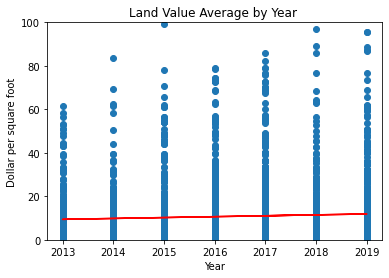

In [373]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()




x=df.loc[df['town_code']==71].sale_year.values.reshape(-1,1)
y=df.loc[df['town_code']==71].dollar_per_sq_foot_land.values.reshape(-1,1)
lr.fit(x,y)
y_pred=lr.predict(x)
# df.loc[df['town_code']==71].plot(kind='scatter', x='sale_year', y='dollar_per_sq_foot_land', figsize=(9,6))
plt.scatter(x,y)
plt.plot(x,y_pred,color='red')
plt.ylim(0, 100)
plt.title('Logan Squar Land Value Average by Year ')
plt.xlabel('Year')
plt.ylabel('Dollar per square foot');

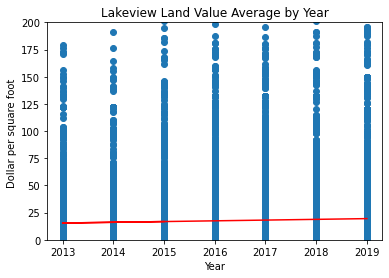

In [374]:
# df.loc[df['town_code']==73].plot(kind='scatter', x='sale_year', y='dollar_per_sq_foot_land', figsize=(9,6));


from sklearn.linear_model import LinearRegression
lr=LinearRegression()

x=df.loc[df['town_code']==73].sale_year.values.reshape(-1,1)
y=df.loc[df['town_code']==73].dollar_per_sq_foot_land.values.reshape(-1,1)
lr.fit(x,y)
y_pred=lr.predict(x)
# df.loc[df['town_code']==71].plot(kind='scatter', x='sale_year', y='dollar_per_sq_foot_land', figsize=(9,6))
plt.scatter(x,y)
plt.plot(x,y_pred,color='red')
plt.ylim(0, 200)
plt.title('Lakeview Land Value Average by Year')
plt.xlabel('Year')
plt.ylabel('Dollar per square foot ');

It appears in both scatterplots that the price of land has increased slightly from year to year. I have broken down the numbers in this method that draws from the original csv doc from Cook County assessors office, meaning it is looking at all homes between 2013 and 2019. It shows the average price of square foot of land for a particular neighborhod. In this case we can see that the average price of square foot of land in lakeview has increased 68% between 2013 and 2019.

In [378]:
def get_land_value_avg(year,tc):
    r=df.loc[df['town_code']==tc]
    t=r.loc[df['sale_year']==year]
    return round(t.loc[df['property_class']==211].dollar_per_sq_foot_land.mean(),2)
x=[get_land_value_avg(2013,71),get_land_value_avg(2014,71),get_land_value_avg(2015,71),get_land_value_avg(2016,71),get_land_value_avg(2017,71),get_land_value_avg(2018,71), get_land_value_avg(2019,71)]
x, round((x[-1]/x[0])-1,2)
# for neighborhoods that require 'town_and_neighborhood code, run thi method()'
# def get_land_value_avg_t_n(year,tc):
#     r=df.loc[df['town_and_neighborhood']==tc]
#     t=r.loc[df['sale_year']==year]
#     return round(t.loc[df['property_class']==211].dollar_per_sq_foot_land.mean(),2)

([12.4, 12.43, 12.53, 13.79, 13.77, 13.66, 16.54], 0.33)

While Logan square is significantly less valuable than property in lakeview, and it is increasing in value at a slower rate. Logan square has increased in value 33% over the same ammount of time that lakeview has increased 47%, meaning that if an investor has enough capital to invest up front Lakeview would return the best long term earnings.

In [379]:
def get_land_value_avg(year,tc):
    r=df.loc[df['town_code']==tc]
    t=r.loc[df['sale_year']==year]
    return round(t.loc[df['property_class']==211].dollar_per_sq_foot_land.mean(),2)
x=[get_land_value_avg(2013,73),get_land_value_avg(2014,73),get_land_value_avg(2015,73),get_land_value_avg(2016,73),get_land_value_avg(2017,73),get_land_value_avg(2018,73), get_land_value_avg(2019,73)]
x, round((x[-1]/x[0])-1,2)






([40.82, 42.09, 42.9, 53.58, 54.42, 52.38, 59.86], 0.47)

Next we look at ways of analyzing how many units and how many bedrooms we want our property to have. Our options are limited since we are only looking at 2, 3,and 4 unit buildings. Naturally a 3 or 4 unit building presents a greater opportunity for rental income, but more units also means more operating and maintenance costs. So, we need to know the potential for rental income given a particular neighborhood.

Below we have a tool for analyzing a zip code's rental profile. You can rerference the "town_dict" to selct a zip code or any other zip code you are intrerested in. This will make an api call from Realty Mole and return a small dataframe outlining the average, minimum, maximum, and total count of rentals for that zip code over that past six months. Please note that the data frame does not have two index columns. The second column marks the number of bedrooms with a 0 being a studio apartment and a 5 being a 5 bedroom unit. 

Because this API call does not give us the option of filtering for only multi-family units, these numbers include multi-family units, apartments, condos for rent and single-family homes. However, even if you are looking to rent out an apartment from a multi-family home all of your competition will be any unit availblle, so it's best to see what rental units of all tyes are currently listed.

In [89]:
def zip_rental_index(zip):
   
    
    url = f"https://realty-mole-property-api.p.rapidapi.com/zipCodes/{zip}"

    headers = {
        'x-rapidapi-host': "realty-mole-property-api.p.rapidapi.com",
        'x-rapidapi-key': "d56849aa27mshace4785d9245bc1p1835d3jsnd5804c70b5c5"
        }
    response = requests.request("GET", url, headers=headers)
    x=response.json()
    x1=x['rentalData']['detailed']
    df_zip_rental_index=df_rental_index=pd.DataFrame(x1)
    return df_zip_rental_index

Let's compare a zip code from Lincoln park, 60614, and from Pilsen, 60608.
Each data frame shows what the average rent is for a 0+ bedroom apartment. In this case 0 equates to a studio apartment. 

In [ ]:
z=zip_rental_index(60614)

In [380]:
z

,bedrooms,averageRent,minRent,maxRent,totalRentals
0,0,1232.58,705,10955,804
1,1,1672.80,600,4550,1480
2,2,2250.95,900,7300,1496
3,3,3100.32,1250,8400,730
4,4,4438.42,2000,15995,188
5,5,7554.85,3200,19500,40
6,6,9532.83,3500,18000,12
7,7,14975.00,14950,15000,2


In [ ]:
c=zip_rental_index(60608)

In [239]:
c

,bedrooms,averageRent,minRent,maxRent,totalRentals
0,0,970.00,759,1300,7
1,1,1272.79,500,2600,179
2,2,1524.12,800,3800,395
3,3,1892.57,1000,4250,196
4,4,2366.75,500,4095,55
5,5,2782.75,2200,3200,8
6,6,8300.00,8300,8300,1


In [240]:
z.totalRentals.sum()

4752

In [241]:
c.totalRentals.sum()

841

In [141]:
z1=z.loc[z['bedrooms']==1].averageRent
z2=z.loc[z['bedrooms']==2].averageRent
z3=z.loc[z['bedrooms']==3].averageRent
z4=z.loc[z['bedrooms']==4].averageRent

In [142]:
c1=c.loc[c['bedrooms']==1].averageRent
c2=c.loc[c['bedrooms']==2].averageRent
c3=c.loc[c['bedrooms']==3].averageRent
c4=c.loc[c['bedrooms']==4].averageRent

Below are the differences between how much is being charged in Lincoln Park and Pilsen based on the number of bedrooms. As we can see, there a big difference in rental rates for these two zip codes, and the ammount of rent that can be earned increases exponentially with each additional bedroom. You can get 400 more a month for a one bedroom apartment in Lincoln Park than you can in Pilsen, while this is significant you can get $1207 dollars more per unit in Lincoln Park than you can for an equal unit in Pilsen. This maens you can get 48 percent more for a 2 bed apartment in Lincoln Park vs Pilsen and 64 percent more if you compare three bedroom aprtments.

In [382]:
z1-c1,z2-c2, z3-c3, z4-c4,(z2/c2)-1,(z3/c3)-1


(1    400.01
 Name: averageRent, dtype: float64,
 2    726.83
 Name: averageRent, dtype: float64,
 3    1207.75
 Name: averageRent, dtype: float64,
 4    2071.67
 Name: averageRent, dtype: float64,
 2    0.476885
 Name: averageRent, dtype: float64,
 3    0.638153
 Name: averageRent, dtype: float64)

Now that we are able to compare rent averages from different neighborhoods we can start asking questions about how many units would be appropriate. Let's say we are considering a two flat building in Lincoln Park and a three flat in Pilsen. We know that rents are definitely higher in Lincoln park, but the building's profitability is altered consideriably depending on the number of bedrooms and units.

In this scenario let's compare a 2 flat in Lincoln Park where each unit has 1 bedroom with a 3 flat in Pilsen that has 3 units with 3 bedrooms. The Pilse property is projcected to earn 2332.11 more per month

In [173]:
# Lincoln Park 2 units 1 bedroom a piece
# Pilsen 3 units at 3 bedrooms a piece
z1*2, c3*3

(1    3345.6
 Name: averageRent, dtype: float64,
 3    5677.71
 Name: averageRent, dtype: float64)

The building in Pilsen projects to be far more profitable than the Lincoln park properety, but let's see how the two properties would compare if the number of rooms were reversed but the number of units stayed the same. 

It turns out that the Lincon park property could out-earn the Pilsen property by  2382.27 a month.

In [392]:
# Lincoln Park 2 units 3 bedroom a piece
# Pilsen 3 units at 1 bedroom a piece

z3*2, c1*3, 

(3    6200.64
 Name: averageRent, dtype: float64,
 1    3818.37
 Name: averageRent, dtype: float64)

Let's go back to the same number of bedrooms but switch the number of units. Here the Lincoln Park property is still more valuable.

The Lincoln Park unit will still out-earn the Pilsen property by 1,233.26 a month.

In [175]:
# Lincoln Park 3 units 1 bedroom a piece
# Pilsen 2 units at 3 bedrooms a piece
z1*3, c3*2

(1    5018.4
 Name: averageRent, dtype: float64,
 3    3785.14
 Name: averageRent, dtype: float64)

Another way to visualize similar data is through a correlation heat map. Below are some heat maps for Lincoln Park and Pilsen. Each square is cross-referenced with other columns from the same data frame. 

One of the big differences that stands out is that Lincoln Park has a higher correlation between averageRent and number of bedrooms at .93 than Pilsen does at .79. Lincoln park's avgerageRent has a higher corrrelation with the minRent .91 than it does with the maxRent .66. Pilsen has a much tighter window with averagRent having a minRent correlation of .98 and maxRent corrrelation of .93.

In essence, the average rent in Lincoln park is much closer to the minRent than it is the maxRent while the avergeRent in Pilsen is very close to min and maxRent meaning that there is a much higher variation of rent prices in Lincoln Park than there is in Pilsen. If you wanted to buy in Pilsen the number of bedrooms has less impact on rental revenue than number of bedrooms do in Lincoln Park. So, if you wanted the property with the greatest potential for rental revenue look for properties in Lincoln Park with the most bedrooms in the most units. 

However, let's say a property in Lincoln Park is out of your budget. If you decide to buy in Pilsen then you still want the most units with the most bedrooms in order to maximize revenue. But if you are looking at two properties in Pilsen and the one with fewer rental units or bedrooms is in much better condition or at a better price point than one with more bedrooms and units, then you may be better off going with the property with less units or less overall bedrooms since there is much less fluctuation in minRent,averageRent,and maxRent in Pilsen than there is in Lincoln Park.



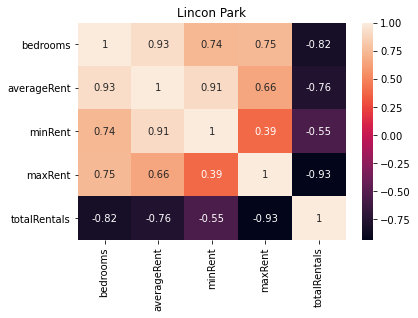

In [267]:
plt.title('Lincon Park')
corrMatrix = z.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()


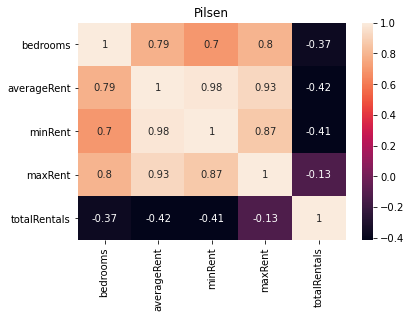

In [268]:
plt.title('Pilsen')
corrMatrix = c.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

Perhaps, you are an investor who is looking to buy, renovate and resell the home in less than a year. If this is the case then rent revenue only matters in terms of resale value, so instead you are more interseted in property attributes that have a high correlation with the sale price.

Immediately below we have a heat map based on the df_cv dataframe we have been working with (all multifamily units sold since 2017 minus properties with a sale price of 1 dollar or less). A good indicator of a properties value is the actual sale price since this is a reflection of what the market says it's worth. We can see from this map that 
the overall number of rooms has a higher correlation with sale price than does number of bedrooms or number of units: .45-rooms, .34-apartments, .39-bedrooms. The number of rooms has a definitive if not significant higher correlation with sale price than apartments or bedrooms. But if we break this heat manp and compareby year we  see that from 2017 to 2019 the correlation between overall number of rooms has risen from .39 in 2017, .44 in 2018, to .51 in 2019, while the correlation between apartments, bedrooms, and sale price fluctuates slightly up and down over the same period of time. 

This tells us that over the past three years the market tends to value properties with the highest number of rooms, bedroom or otherwise. So, if you are looking for a multi-family home in Pilsen, then homes with the highest number of rooms perform better at holding or increasing their resale value .

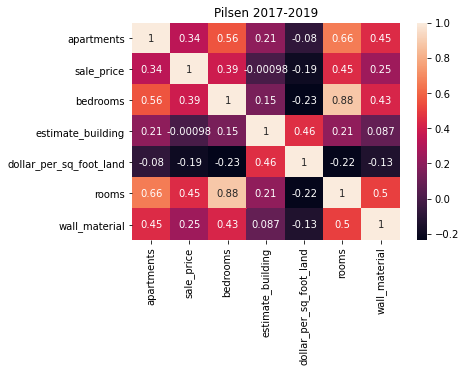

In [404]:
plt.title('Pilsen 2017-2019')
# pilsen.loc[pilsen['building_square_feet']!=isna()]
p1= pd.DataFrame(pilsen,columns=['apartments','sale_price','bedrooms','estimate_building','dollar_per_sq_foot_land','rooms','wall_material'])
corrMatrix = p1.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

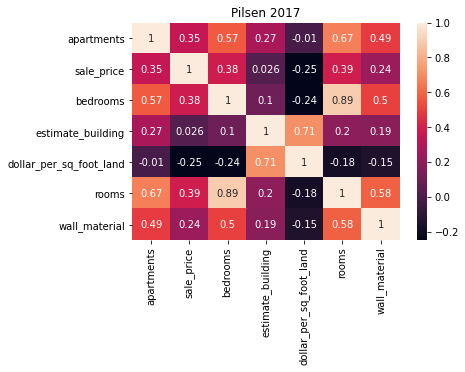

In [280]:
plt.title('Pilsen 2017')
p1= pd.DataFrame(pilsen.loc[pilsen['sale_year']==2017],columns=['apartments','sale_price','bedrooms','estimate_building','dollar_per_sq_foot_land','rooms','wall_material'])
corrMatrix = p1.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()



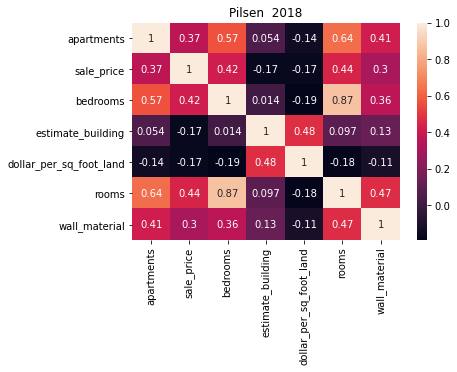

In [282]:
plt.title('Pilsen  2018')
p1= pd.DataFrame(pilsen.loc[pilsen['sale_year']==2018],columns=['apartments','sale_price','bedrooms','estimate_building','dollar_per_sq_foot_land','rooms','wall_material'])
corrMatrix = p1.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

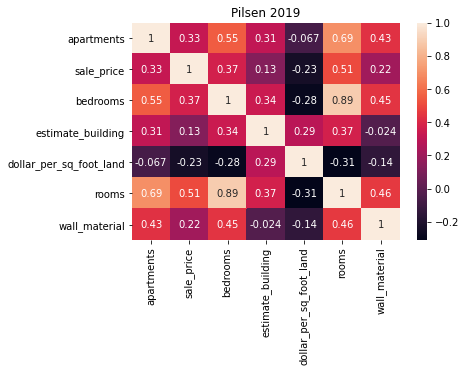

In [283]:
plt.title('Pilsen 2019')
p1= pd.DataFrame(pilsen.loc[pilsen['sale_year']==2019],columns=['apartments','sale_price','bedrooms','estimate_building','dollar_per_sq_foot_land','rooms','wall_material'])
corrMatrix = p1.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

In the final section we'll value property based on rental listings in the imdeiate vicinity of our property . 

The rental_comps() tool below is similar to the zip_rental_index() outlined above.It makes an API call to Realty Mole and returns a dataframe that displays nearby rental rates. 

Let's search for a place in Bridgeport with the following attributes. It must have at least 3 units and 2 bedrooms per unit and brick exterior walls plus a garage. 

At the top of the list in 3352 S Lituanica Ave. Its land estimate value is considerably higher than other properties, but its dollar per square foot of land value is the same. This property is a double lot with a 4 unit building. This double lot is 6500 square feet and is more thandouble the size of a standard multi-family lot, which is roughly 3000 square feet. 

Should, I investigate this property further as a potential investment, or do I opt for a property that has fewer units and sits on a smaller piece of land? More units means more rental income, but because this is a double lot it will cost more to acquire twice as much land for only one more unit. Lot sizes do not have a large impact what you collect in rent, but it can have an impact on taxes, insurance and capital required for investment.

Let' compare 3352 S Lituanica Ave with the property directly below it, 3400 S ABERDEEN ST.

In [299]:
b1=bridgeport.loc[bridgeport['apartments']>=3]
b2=b1.loc[b1['bedrooms']>=6]
b3=b2.loc[b2['wall_material']==2]
b4=b3.loc[b3['garage_indicator']==1]
b4.sort_values('sale_price', ascending=False)

,pin,property_class,land_square_feet,town_code,type_of_residence,apartments,wall_material,roof_material,rooms,bedrooms,basement,basement_finish,central_heating,other_heating,central_air,fireplaces,attic_type,attic_finish,half_baths,multi_code,estimate_land,estimate_building,sale_date,deed_no.,sale_price,property_address,full_baths,age,sale_year,sale_quarter,most_recent_sale,age_decade,garage_indicator,neigborhood_code_(mapping),town_and_neighborhood,dollar_per_sq_foot_land
27226,17322200430000,211,6500.0,76,2.0,4.0,2.0,2.0,22.0,8.0,1.0,3.0,2.0,5.0,0.0,0.0,3.0,0,0.0,2.0,208000,334960,10/01/2019,1927457133,710000,3352 S LITUANICA AVE,6.0,89,2019,92,1.0,8.9,1.0,50,7650,32.000000
1028,17322161760000,211,3025.0,76,3.0,3.0,2.0,2.0,18.0,9.0,1.0,3.0,2.0,5.0,0.0,0.0,3.0,0,0.0,2.0,96800,417000,04/12/2019,1910213100,624000,3400 S ABERDEEN ST,3.0,124,2019,90,1.0,12.4,1.0,50,7650,32.000000
30606,17293070630000,211,2875.0,76,2.0,3.0,2.0,1.0,12.0,8.0,1.0,2.0,1.0,5.0,1.0,0.0,3.0,0,0.0,2.0,71870,366780,09/20/2017,1726310047,520000,2516 S THROOP ST,3.0,20,2017,83,1.0,2.0,1.0,50,7650,24.998261
4598,17322020300000,211,2976.0,76,2.0,3.0,2.0,1.0,14.0,6.0,1.0,2.0,2.0,5.0,0.0,0.0,1.0,3,0.0,2.0,74400,185610,07/25/2018,1820633166,497500,1022 W 31ST PL,3.0,120,2018,87,1.0,12.0,1.0,50,7650,25.000000
17124,17321100420000,211,2976.0,76,2.0,3.0,2.0,1.0,11.0,6.0,1.0,3.0,1.0,5.0,0.0,0.0,2.0,3,0.0,2.0,74400,245760,10/10/2017,1728304028,490000,3244 S RACINE AVE,3.0,102,2017,84,1.0,10.2,1.0,50,7650,25.000000
13225,17294080250000,211,3267.0,76,2.0,3.0,2.0,1.0,12.0,6.0,2.0,3.0,2.0,5.0,0.0,0.0,1.0,3,0.0,2.0,81670,214410,07/05/2018,1818629394,486000,2955 S LOOMIS ST,3.0,89,2018,87,1.0,8.9,1.0,50,7650,24.998470
17289,17322161690000,211,3125.0,76,2.0,3.0,2.0,1.0,11.0,6.0,1.0,1.0,1.0,5.0,0.0,0.0,1.0,3,0.0,2.0,100000,351060,04/10/2019,1910006085,469500,3342 S ABERDEEN ST,3.0,120,2019,90,1.0,12.0,1.0,50,7650,32.000000
560,17322161490000,211,3577.0,76,2.0,3.0,2.0,1.0,14.0,6.0,1.0,2.0,1.0,5.0,0.0,0.0,3.0,0,0.0,2.0,89420,264260,04/17/2018,1810708004,425000,3250 S ABERDEEN ST,3.0,108,2018,86,1.0,10.8,1.0,50,7650,24.998602
17651,17294260990000,211,2875.0,76,2.0,3.0,2.0,2.0,15.0,6.0,1.0,3.0,2.0,5.0,0.0,0.0,3.0,0,0.0,2.0,92000,298470,05/30/2019,1915049236,415000,3024 S POPLAR AVE,3.0,130,2019,90,1.0,13.0,1.0,50,7650,32.000000
7321,17321030110000,211,2976.0,76,2.0,4.0,2.0,1.0,15.0,8.0,1.0,3.0,0.0,5.0,0.0,0.0,3.0,0,0.0,2.0,95230,263920,08/12/2019,1922145082,320000,1333 W 31ST ST,4.0,130,2019,91,1.0,13.0,1.0,50,7650,31.999328


Before we move onto the rental comp portion, it's worth pointing out the property at indexes 19345 and 19346, 920 W 32nd Pl. 

This property was sold twice in the span of 2 months. The first sale price is $101,000 and the second is $215,000. A quick zillow search for 920 W 32ND PL Chicago IL reveals that the home was indeed sold in 2018 for $215,000, and the only picture of the proprty shows construction permits posted on the front. The buiding was likely bought, quickly rehabbed, and sold in a little over two months for a profit of $114,000. So if you are looking for properties to flip, the property at 920 W 32nd PL tells us that it's possible to make 100k in two months provided you have the means to rehab a place that quickly. Follow this link: 

https://www.zillow.com/homes/920-W-32ND-PL%09_rb/2088860748_zpid/	



In [360]:
df.loc[df['property_address']=='920 W 32ND PL']

,pin,property_class,neighborhood_code,land_square_feet,town_code,type_of_residence,apartments,wall_material,roof_material,rooms,bedrooms,basement,basement_finish,central_heating,other_heating,central_air,fireplaces,attic_type,attic_finish,half_baths,design_plan,cathedral_ceiling,construction_quality,renovation,site_desirability,garage_1_size,garage_1_material,garage_1_attachment,garage_1_area,garage_2_size,garage_2_material,garage_2_attachment,garage_2_area,porch,other_improvements,building_square_feet,repair_condition,multi_code,number_of_commercial_units,estimate_land,estimate_building,sale_date,deed_no.,sale_price,longitude,latitude,census_tract,total_building_square_feet,multi_property_indicator,property_address,modeling_group,full_baths,age,use,number_of_units,percent_ownership,condo_class_factor,multi-family_indicator,large_lot,"condition,_desirability_and_utility",o'hare_noise,floodplain,road_proximity,condo_strata,sale_year,sale_quarter,sale_half-year,sale_quarter_of_year,sale_month_of_year,sale_half_of_year,most_recent_sale,age_squared,age_decade,age_decade_squared,lot_size_squared,improvement_size_squared,pure_market_filter,garage_indicator,neigborhood_code_(mapping),square_root_of_lot_size,square_root_of_age,square_root_of_improvement_size,town_and_neighborhood,dollar_per_sq_foot_land
329365,17322120310000,211,50,2500.0,76,2.0,4.0,2.0,1.0,16.0,6.0,2.0,3.0,1.0,2.0,0.0,0.0,3.0,0,0.0,2.0,2.0,2.0,NaN,2.0,3.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,3,0.0,2520.0,2.0,2.0,0.0,62500,222510,06/27/2018,1817819016,101000,-87.649565,41.835813,600900.0,NaN,0,920 W 32ND PL,MF,4.0,120,2,NaN,NaN,NaN,211.0,NaN,NaN,0.0,0.0,0.0,NaN,2018,86,43,2,6,1,0.0,14400,12.0,144.0,6250000.0,6350400.0,1,1.0,50,50.0,10.954451,50.199602,7650,25.0
329366,17322120310000,211,50,2500.0,76,2.0,4.0,2.0,1.0,16.0,6.0,2.0,3.0,1.0,2.0,0.0,0.0,3.0,0,0.0,2.0,2.0,2.0,NaN,2.0,3.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,3,0.0,2520.0,2.0,2.0,0.0,62500,222510,09/05/2018,1824813017,215000,-87.649565,41.835813,600900.0,NaN,0,920 W 32ND PL,MF,4.0,120,2,NaN,NaN,NaN,211.0,NaN,NaN,0.0,0.0,0.0,NaN,2018,87,44,3,9,2,1.0,14400,12.0,144.0,6250000.0,6350400.0,1,1.0,50,50.0,10.954451,50.199602,7650,25.0


3352 S Lituanica Ave has 4 units with 2 bedrooms a piece.
3400 S ABERDEEN ST has 3 units with 3 bedrooms a piece. 

Directly below I'll use the zip rental index tool to estimate how each property's revenue




In [301]:
# Returns a rental profile for the Bridgeport Zip code
b=zip_rental_index(60609)


In [354]:
b

,bedrooms,averageRent,minRent,maxRent,totalRentals
0,0,1035.00,1035,1035,1
1,1,1111.67,500,1500,15
2,2,1222.17,700,2250,69
3,3,1433.09,450,2700,47
4,4,2266.67,1250,3250,9
5,6,1650.00,1650,1650,1


In [321]:
# Expected rental income from 3352 S Lituanica Ave
bport_avg_rent_2b=1222.17
Lit_rev=4*bport_avg_rent_2b
print(f'Lit Rev per month: {Lit_rev}')
print(f'Lit Rev per year: {Lit_rev*12}')
print('='*20)
#  Expected rental income from 3400 S Aberdeen 3 apartments and 9 bedrooms
bport_avg_rent_3b=1433.09
Ab_rev=3*bport_avg_rent_3b
print(f'Ab Rev per month: {round(Ab_rev,2)}')
print(f'Ab Rev per year: {round(Ab_rev*12,2)}')
print('='*20)
print(f'Difference in 1 year of revenue: {round((Lit_rev*12)-(Ab_rev*12),2)}')
print(f'Difference in sale price: {710000-624000}')
print(f'1 year difference in revenue per month: {round((Lit_rev*12)-(Ab_rev*12),2)/12}')

Lit Rev per month: 4888.68
Lit Rev per year: 58664.16
Ab Rev per month: 4299.27
Ab Rev per year: 51591.24
Difference in 1 year of revenue: 7072.92
Difference in sale price: 86000
1 year difference in revenue per month: 589.41


The 4 unit property at Lituanica will outproduce the 3 unit property on Aberdeen by $7,072.92 per year or $598.41 a month. Meaning that paying an additional $86,000 dollars for the 4 unit property will earn you an additional $7,072.92 a year. Based on the caluculations below we see that's an 8.2% return on investment on the additional ammount paid for the property on Lituanica.

In [356]:
print(f'Return on investment for additional money paid {round((589.41/86000)*12, 3)}')

Return on investment for additional money paid 0.082


The Zip rental index is good, but both properties are in the same neighborhood, so we need a more precise estimate of each property's capabilities.

Below is a method that makes an API call from Realty Mole. This will allow the user to search nearby rental listings. The first method will prompt the user for inputs, but we'll be using a modified version in order to convert the method into a dataframe



In [335]:
def rental_comps():
    print('Please enter desired search criteria')
    state=input('What state are you interested in? Please enter abbreviation:')
    city=input('What city are interested in:')
    address=input('Please enter the street address without the zip code, ex. 123 N Mainstreet:')
    limit=input('You can compare up to 50 properties at a time. How many would you like to compare:')
    radius=input('What is your desired search radius in kilometers:')
    bedrooms=input('How many bedrooms:')
    bathrooms=input('How many bathrooms:')
    
    url = "https://realty-mole-property-api.p.rapidapi.com/rentalListings"
    querystring = {"radius":{radius},"bedrooms":{bedrooms},"bathrooms":{bathrooms},"city":{city.title()},"state":{state.upper()},"limit":{limit},"address":{address.title()}}
    headers = {
        'x-rapidapi-host': "realty-mole-property-api.p.rapidapi.com",
        'x-rapidapi-key': "d56849aa27mshace4785d9245bc1p1835d3jsnd5804c70b5c5"
        }

    rental_comp = requests.request("GET", url, headers=headers, params=querystring)

    q=rental_comp.json()
    df_rental_comp=pd.DataFrame(q)
    return df_rental_comp





# This method is useful if you want to save a dataframe for particular property.
def df_rental_comps(state, city, address, limit, radius, bedrooms, bathrooms):
    url = "https://realty-mole-property-api.p.rapidapi.com/rentalListings"
    querystring = {"radius":{radius},"bedrooms":{bedrooms},"bathrooms":{bathrooms},"city":{city.title()},"state":{state.upper()},"limit":{limit},"address":{address.title()}}
    headers = {
        'x-rapidapi-host': "realty-mole-property-api.p.rapidapi.com",
        'x-rapidapi-key': "d56849aa27mshace4785d9245bc1p1835d3jsnd5804c70b5c5"
        }

    rental_comp = requests.request("GET", url, headers=headers, params=querystring)

    q=rental_comp.json()
    df_rental_comp=pd.DataFrame(q)
    return df_rental_comp


In [344]:
Lit_rental_comps=df_rental_comps("IL", 'Chicago', '3352 S LITUANICA AVE',30,.75,2,1)
Lit_rental_comps

,bathrooms,bedrooms,price,rawAddress,squareFootage,county,propertyType,addressLine1,addressLine2,city,state,zipCode,formattedAddress,lastSeen,listedDate,status,removedDate,daysOnMarket,createdDate,id,latitude,longitude
0,1,2,1000,"940 W 31st Pl Unit 1F, Chicago, Illinois 60608",900.0,Cook County,Apartment,940 W 31st Pl,Unit 1F,Chicago,IL,60608,"940 W 31st Pl, Unit 1F, Chicago, IL 60608",2020-10-14T03:31:27.697Z,2020-10-08T03:19:47.051Z,Active,None,7,2020-09-08T04:01:26.313Z,"940-W-31st-Pl,-Unit-1F,-Chicago,-IL-60608",41.837433,-87.650349
1,1,2,1000,"3356 S Emerald Ave Apt 2R, Chicago, Illinois 6...",950.0,Cook County,Condo,3356 S Emerald Ave,Apt 2R,Chicago,IL,60616,"3356 S Emerald Ave, Apt 2R, Chicago, IL 60616",2020-10-14T03:27:04.668Z,2020-10-13T02:23:24.175Z,Active,None,2,2020-08-21T07:13:40.081Z,"3356-S-Emerald-Ave,-Apt-2R,-Chicago,-IL-60616",41.832772,-87.645282
2,1,2,1275,"3254 S Morgan St, Chicago, Illinois 60608",NaN,Cook County,Apartment,3254 S Morgan St,NaN,Chicago,IL,60608,"3254 S Morgan St, Chicago, IL 60608",2020-10-14T03:23:56.443Z,2020-10-14T03:23:56.443Z,Active,None,0,2020-10-14T03:23:56.443Z,"3254-S-Morgan-St,-Chicago,-IL-60608",41.834576,-87.651412
3,1,2,1200,"1015 W 31st Pl Unit 1R, Chicago, Illinois 60608",800.0,Cook County,Condo,1015 W 31st Pl,Unit 1R,Chicago,IL,60608,"1015 W 31st Pl, Unit 1R, Chicago, IL 60608",2020-10-14T03:22:50.505Z,2020-10-08T03:05:05.551Z,Active,None,7,2019-07-13T04:12:40.620Z,"1015-W-31st-Pl,-Unit-1R,-Chicago,-IL-60608",41.836800,-87.651804
4,1,2,1200,"3254 S Morgan St Apt 3R, Chicago, Illinois 60608",800.0,Cook County,Apartment,3254 S Morgan St,Apt 3R,Chicago,IL,60608,"3254 S Morgan St, Apt 3R, Chicago, IL 60608",2020-10-14T03:20:32.135Z,2020-10-12T02:43:02.423Z,Active,None,3,2020-10-12T02:43:02.423Z,"3254-S-Morgan-St,-Apt-3R,-Chicago,-IL-60608",41.834576,-87.651412
5,1,2,1600,"3254 S Morgan Copy 2 Unit 3F, Chicago, Illinoi...",800.0,Cook County,Apartment,3254 S Morgan Copy 2,Unit 3F,Chicago,IL,60608,"3254 S Morgan Copy 2, Unit 3F, Chicago, IL 60608",2020-10-13T03:44:27.715Z,2020-10-09T03:09:54.590Z,Active,None,5,2020-10-09T03:09:54.590Z,"3254-S-Morgan-Copy-2,-Unit-3F,-Chicago,-IL-60608",41.834575,-87.651414
6,1,2,1200,"938 W 34th St, Chicago, Illinois 60608",NaN,Cook County,Apartment,938 W 34th St,NaN,Chicago,IL,60608,"938 W 34th St, Chicago, IL 60608",2020-10-13T03:44:11.283Z,2020-10-10T03:22:34.424Z,Active,None,4,2020-10-10T03:22:34.424Z,"938-W-34th-St,-Chicago,-IL-60608",41.833043,-87.650127
7,1,2,1500,"3259 S Union Ave Apt 3M, Chicago, Illinois 60616",1500.0,Cook County,Condo,3259 S Union Ave,Apt 3M,Chicago,IL,60616,"3259 S Union Ave, Apt 3M, Chicago, IL 60616",2020-10-12T03:39:49.055Z,2020-10-03T03:42:19.769Z,Inactive,2020-10-14T04:02:12.510Z,12,2020-10-03T03:42:19.769Z,"3259-S-Union-Ave,-Apt-3M,-Chicago,-IL-60616",41.834561,-87.643406
8,1,2,1200,"844 W 33rd St Apt 2F, Chicago, Illinois 60608",500.0,Cook County,Single Family,844 W 33rd St,Apt 2F,Chicago,IL,60608,"844 W 33rd St, Apt 2F, Chicago, IL 60608",2020-10-08T03:40:21.363Z,2020-10-05T03:16:06.148Z,Inactive,2020-10-10T04:03:11.399Z,6,2020-07-28T00:58:04.382Z,"844-W-33rd-St,-Apt-2F,-Chicago,-IL-60608",41.835046,-87.647961
9,1,2,1050,"3400 S Lituanica Ave Unit 2, Chicago, Illinois...",1100.0,Cook County,Condo,3400 S Lituanica Ave,Unit 2,Chicago,IL,60608,"3400 S Lituanica Ave, Unit 2, Chicago, IL 60608",2020-10-05T03:39:41.540Z,2020-09-26T02:20:48.895Z,Inactive,2020-10-08T04:01:22.455Z,13,2020-07-26T20:46:59.071Z,"3400-S-Lituanica-Ave,-Unit-2,-Chicago,-IL-60608",41.832637,-87.648938


Text(0, 0.5, 'Number of homes')

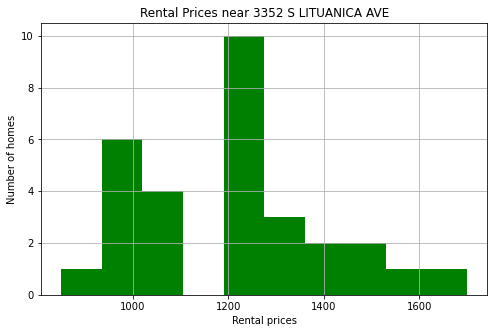

In [367]:
Lit_rental_comps.price.hist(figsize=(8, 5 ),color=['green']);
plt.title('Rental Prices near 3352 S LITUANICA AVE')
plt.xlabel('Rental prices')
plt.ylabel('Number of homes')

In [345]:
round(Lit_rental_comps.describe(),2)

,bathrooms,bedrooms,price,squareFootage,daysOnMarket,latitude,longitude
count,30.0,30.0,30.00,20.00,30.00,30.00,30.00
mean,1.0,2.0,1204.67,905.00,9.10,41.83,-87.65
std,0.0,0.0,202.75,221.18,6.41,0.00,0.00
min,1.0,2.0,850.00,500.00,0.00,41.83,-87.65
25%,1.0,2.0,1062.50,737.50,5.00,41.83,-87.65
50%,1.0,2.0,1200.00,900.00,7.00,41.83,-87.65
75%,1.0,2.0,1290.00,1062.50,12.00,41.84,-87.65
max,1.0,2.0,1700.00,1500.00,27.00,41.84,-87.64


In [339]:
Ab_rental_comps=df_rental_comps("IL", 'Chicago', '3400 S ABERDEEN ST',30,.75,3,1)
# 

In [340]:
Ab_rental_comps

,bathrooms,bedrooms,price,rawAddress,squareFootage,county,propertyType,addressLine1,addressLine2,city,state,zipCode,formattedAddress,lastSeen,listedDate,status,removedDate,daysOnMarket,createdDate,id,latitude,longitude
0,1,3,1195,"915 W 32nd St Unit 3F, Chicago, Illinois 60608",800.0,Cook County,Apartment,915 W 32nd St,Unit 3F,Chicago,IL,60608,"915 W 32nd St, Unit 3F, Chicago, IL 60608",2020-10-14T03:38:33.103Z,2020-10-06T02:16:02.589Z,Active,None,9.0,2020-10-06T02:16:02.589Z,"915-W-32nd-St,-Unit-3F,-Chicago,-IL-60608",41.836160,-87.649383
1,1,3,1600,"3162 S Throop St # 00B, Chicago, Illinois 60608",1400.0,Cook County,Apartment,3162 S Throop St,# 00B,Chicago,IL,60608,"3162 S Throop St, # 00B, Chicago, IL 60608",2020-10-13T03:41:36.379Z,2020-10-10T03:18:43.792Z,Active,None,4.0,2020-10-10T03:18:43.792Z,"3162-S-Throop-St,---00B,-Chicago,-IL-60608",41.836032,-87.658708
2,1,3,1200,"915 W 32nd Copy 2 St Unit 3F, Chicago, Illinoi...",800.0,Cook County,Apartment,915 W 32nd Copy 2 St,Unit 3F,Chicago,IL,60608,"915 W 32nd Copy 2 St, Unit 3F, Chicago, IL 60608",2020-10-09T03:07:55.050Z,2020-10-09T03:07:55.050Z,Inactive,2020-10-11T04:02:13.313Z,3.0,2020-10-09T03:07:55.050Z,"915-W-32nd-Copy-2-St,-Unit-3F,-Chicago,-IL-60608",41.836160,-87.649383
3,1,3,1300,"1012 W 31st Pl Unit 1, Chicago, Illinois 60608",1100.0,Cook County,Condo,1012 W 31st Pl,Unit 1,Chicago,IL,60608,"1012 W 31st Pl, Unit 1, Chicago, IL 60608",2020-10-06T02:28:34.376Z,2020-10-04T02:10:17.778Z,Inactive,2020-10-08T04:01:57.684Z,5.0,2020-10-04T02:10:17.778Z,"1012-W-31st-Pl,-Unit-1,-Chicago,-IL-60608",41.837323,-87.651727
4,1,3,1400,"3089 S Bonfield St Unit 1, Chicago, Illinois 6...",NaN,Cook County,Condo,3089 S Bonfield St,Unit 1,Chicago,IL,60608,"3089 S Bonfield St, Unit 1, Chicago, IL 60608",2020-10-02T03:40:37.554Z,2020-09-23T05:07:41.554Z,Inactive,2020-10-04T03:59:53.269Z,11.0,2020-07-31T17:46:42.793Z,"3089-S-Bonfield-St,-Unit-1,-Chicago,-IL-60608",41.838371,-87.652481
5,1,3,1300,"3201 S Morgan St Apt 3F, Chicago, Illinois 60608",1000.0,Cook County,Condo,3201 S Morgan St,Apt 3F,Chicago,IL,60608,"3201 S Morgan St, Apt 3F, Chicago, IL 60608",2020-09-07T19:26:26.478Z,2020-09-07T19:26:26.478Z,Inactive,2020-09-09T21:20:01.452Z,3.0,2020-07-05T19:09:17.754Z,"3201-S-Morgan-St,-Apt-3F,-Chicago,-IL-60608",41.836264,-87.650765
6,1,3,1350,"3235 S Racine Ave Apt 1R, Chicago, Illinois 60608",1300.0,Cook County,Apartment,3235 S Racine Ave,Apt 1R,Chicago,IL,60608,"3235 S Racine Ave, Apt 1R, Chicago, IL 60608",2020-09-01T08:32:52.170Z,2020-08-10T19:23:55.376Z,Inactive,2020-09-03T21:16:50.593Z,25.0,2020-06-17T19:39:17.530Z,"3235-S-Racine-Ave,-Apt-1R,-Chicago,-IL-60608",41.835069,-87.655595
7,1,3,1500,"839 W 33rd Pl, Chicago, Illinois 60608",NaN,Cook County,Apartment,839 W 33rd Pl,NaN,Chicago,IL,60608,"839 W 33rd Pl, Chicago, IL 60608",2020-08-22T08:11:43.237Z,2020-08-20T19:26:48.668Z,Inactive,2020-08-24T09:17:14.744Z,4.0,2020-08-20T19:26:48.668Z,"839-W-33rd-Pl,-Chicago,-IL-60608",41.833523,-87.647708
8,1,3,2095,"3121 S Morgan St Apt 3, Chicago, Illinois 60608",1500.0,Cook County,Condo,3121 S Morgan St,Apt 3,Chicago,IL,60608,"3121 S Morgan St, Apt 3, Chicago, IL 60608",2020-07-17T20:41:50.716Z,2020-07-08T06:08:36.190Z,Inactive,2020-07-19T21:23:29.571Z,12.0,2020-07-08T06:08:36.190Z,"3121-S-Morgan-St,-Apt-3,-Chicago,-IL-60608",41.837358,-87.650839
9,1,3,1200,"915 W 32nd St Unit 2F, Chicago, Illinois 60608",800.0,Cook County,Apartment,915 W 32nd St,Unit 2F,Chicago,IL,60608,"915 W 32nd St, Unit 2F, Chicago, IL 60608",2020-07-15T20:54:44.988Z,2020-07-10T19:00:15.224Z,Inactive,2020-07-17T21:58:26.632Z,8.0,2020-06-16T18:10:08.776Z,"915-W-32nd-St,-Unit-2F,-Chicago,-IL-60608",41.836160,-87.649383


Text(0, 0.5, 'Number of homes')

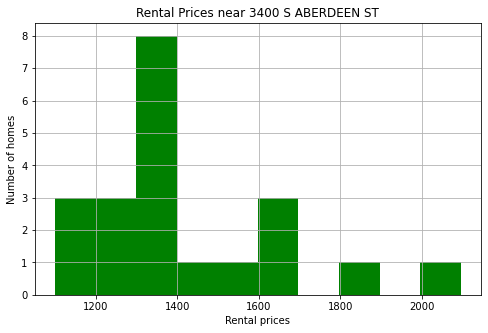

In [366]:
Ab_rental_comps.price.hist(figsize=(8, 5 ),color=['green']);
plt.title('Rental Prices near 3400 S ABERDEEN ST')
plt.xlabel('Rental prices')
plt.ylabel('Number of homes')

In [349]:
Ab_rental_comps.describe()

,bathrooms,bedrooms,price,squareFootage,daysOnMarket,latitude,longitude
count,21.0,21.0,21.000000,15.000000,18.000000,21.000000,21.000000
mean,1.0,3.0,1396.666667,1181.800000,12.333333,41.835241,-87.650677
std,0.0,0.0,236.893084,300.536235,8.977095,0.002246,0.002681
min,1.0,3.0,1100.000000,800.000000,3.000000,41.828949,-87.658708
25%,1.0,3.0,1250.000000,1020.500000,5.000000,41.833523,-87.651430
50%,1.0,3.0,1300.000000,1200.000000,10.000000,41.835945,-87.650711
75%,1.0,3.0,1500.000000,1325.000000,17.250000,41.836264,-87.648952
max,1.0,3.0,2095.000000,1936.000000,34.000000,41.838467,-87.647307


Above we have a dataframe for rental listings near each property, a histogram displaying rent averages for each group, and a description of each dataframe. 

The average rent for 2 bed units near 3352 S Lituanica Ave is 1204.67. The average rent for 3 bed units near 3400 S ABERDEEN ST his 1396.66.

The search for nearby rental listings confirms what the zip code index indicated. Unless 3352 S Lituanica Ave is in an advanced state of disrepair, it projects to outearn 3400 S ABERDEEN ST by 682.70 a month.

In [359]:
print(f'3352 S Lituanica Ave is projected to produce ${1204.67*4} a month')
print(f'3400 S ABERDEEN ST is projected to produce ${round(1396.66*3,2)} a month')
print(f'Projected difference in revenue {round((1204.67*4)-(1396.66*3),2)}')

3352 S Lituanica Ave is projected to produce $4818.68 a month
3400 S ABERDEEN ST is projected to produce $4189.98 a month
Projected difference in revenue 628.7


In [399]:
df.loc[df['property_class']==211].building_square_feet
df_cv['building_square_feet']=df['building_square_feet']
df_cv.head(100)

,pin,property_class,land_square_feet,town_code,type_of_residence,apartments,wall_material,roof_material,rooms,bedrooms,basement,basement_finish,central_heating,other_heating,central_air,fireplaces,attic_type,attic_finish,half_baths,multi_code,estimate_land,estimate_building,sale_date,deed_no.,sale_price,property_address,full_baths,age,sale_year,sale_quarter,most_recent_sale,age_decade,garage_indicator,neigborhood_code_(mapping),town_and_neighborhood,dollar_per_sq_foot_land,building_square_feet
1,20264140050000,211,4687.000000,70,2.0,0.0,2.0,1.0,11.0,4.0,1.0,1.0,2.0,5.0,0.0,0.0,3.0,0,1.0,2.0,46870,133520,07/07/2017,1718806066,63000,1447 E 76TH ST,2.0,92,2017,83,0.0,9.2,1.0,70,7070,10.000000,NaN
4,13144060170000,211,3750.000000,71,2.0,2.0,2.0,1.0,12.0,6.0,1.0,3.0,2.0,5.0,0.0,0.0,3.0,0,0.0,2.0,82500,322220,12/11/2019,1934549318,415000,4317 N SPAULDING AVE,2.0,104,2019,92,1.0,10.4,1.0,82,7182,22.000000,NaN
5,20103010620000,211,4025.000000,70,2.0,2.0,2.0,2.0,12.0,6.0,1.0,3.0,2.0,5.0,0.0,0.0,3.0,0,0.0,2.0,56350,174240,05/11/2017,1713106091,170000,5147 S WABASH AVE,2.0,127,2017,82,1.0,12.7,0.0,10,7010,14.000000,4692.0
6,19242060240000,211,3750.000000,72,2.0,2.0,2.0,2.0,10.0,4.0,1.0,1.0,2.0,5.0,0.0,0.0,3.0,0,0.0,2.0,26250,134730,05/07/2018,1812734010,70000,6324 S ARTESIAN AVE,2.0,102,2018,86,0.0,10.2,0.0,71,7271,7.000000,NaN
7,19242060240000,211,3750.000000,72,2.0,2.0,2.0,2.0,10.0,4.0,1.0,1.0,2.0,5.0,0.0,0.0,3.0,0,0.0,2.0,26250,134730,06/05/2018,1815606000,78000,6324 S ARTESIAN AVE,2.0,102,2018,86,0.0,10.2,0.0,71,7271,7.000000,NaN
11,19244080160000,211,3750.000000,72,2.0,4.0,2.0,1.0,18.0,8.0,1.0,3.0,2.0,5.0,0.0,0.0,1.0,3,0.0,2.0,26250,18150,07/23/2018,1820045061,135500,6800 S ROCKWELL ST,4.0,90,2018,87,0.0,9.0,1.0,150,72150,7.000000,2538.0
12,10223070200000,211,5658.000000,24,2.0,4.0,2.0,1.0,16.0,8.0,1.0,3.0,1.0,5.0,0.0,0.0,3.0,0,0.0,2.0,41020,380870,08/29/2017,1724146153,480000,8319 KEATING AVE,4.0,66,2017,83,1.0,6.6,0.0,31,2431,7.249912,984.0
16,18034220670000,211,7980.000000,21,2.0,4.0,2.0,1.0,16.0,8.0,1.0,1.0,1.0,5.0,0.0,0.0,3.0,0,0.0,2.0,39900,247880,05/10/2017,1713012076,475000,4538 GROVE AVE,4.0,42,2017,82,1.0,4.2,1.0,42,2142,5.000000,1673.0
17,13363170190000,211,2950.000000,77,3.0,3.0,2.0,2.0,17.0,6.0,1.0,3.0,2.0,5.0,0.0,0.0,3.0,0,0.0,2.0,66370,343810,11/15/2018,1831912063,610000,1709 N TROY ST,3.0,128,2018,88,1.0,12.8,1.0,30,7730,22.498305,1140.0
18,13142250130000,211,3750.000000,71,2.0,2.0,2.0,2.0,10.0,4.0,1.0,3.0,1.0,5.0,0.0,0.0,3.0,0,0.0,2.0,48750,251060,11/02/2018,1830545066,455000,4421 N KIMBALL AVE,2.0,103,2018,88,1.0,10.3,1.0,81,7181,13.000000,NaN
